In [9]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import *
from pyspark.ml.regression import GBTRegressor
import numpy as np

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [10]:
df = spark.read.parquet('../data/curated/merchant_consumer_abs')

In [11]:
df

22/10/05 23:07:33 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


postcode,total_earners,median_age,income_sum,income_median,income_mean,2021_population,km2,persons/km2,merchant_name,revenue_level,user_id,order_datetime,products,take_rate,category,dollar_value,order_year,order_month,order_day,consumer,consumer_address,consumer_state,consumer_postcode,consumer_gender,fraud_group,__index_level_0__
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Elit Sed Consequa...,a,10413,2022-04-27,artist supply and...,5.89,art and gifts,375.16773164703153,2022,4,27,Kelly Clayton,4211 Rodney Tunne...,NT,0800,Female,0,0
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Elit Sed Consequa...,a,22246,2022-10-07,artist supply and...,5.89,art and gifts,617.8791313462011,2022,10,7,Corey Estrada,1703 Boyd Shore,NT,0800,Male,0,1
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Elit Sed Consequa...,a,2681,2022-02-28,artist supply and...,5.89,art and gifts,766.5077067424303,2022,2,28,Nicole Bishop,467 Robert Island...,NT,0800,Female,0,2
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Malesuada Vel Ltd,b,13454,2021-07-24,books periodicals...,3.56,books and music,258.86595899218753,2021,7,24,Natalie Herrera,88798 Saunders Hi...,NT,0800,Female,0,3
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Varius Orci Insti...,a,10146,2021-08-08,tent and awning s...,6.3,outdoors,4.159037931172075,2021,8,8,Shannon Mann,00817 Owens Circle,NT,0800,Female,0,4
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Volutpat Nulla In...,a,23093,2022-10-11,furniture home fu...,6.59,home and technology,8.26105405068297,2022,10,11,Robert Walker,646 Allison Ranch...,NT,0800,Male,0,5
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Mollis Integer Co...,b,13454,2022-05-02,digital goods boo...,3.96,books and music,83.63154755239155,2022,5,2,Natalie Herrera,88798 Saunders Hi...,NT,0800,Female,0,6
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Elit Sed Consequa...,a,13454,2021-04-08,artist supply and...,5.89,art and gifts,87.00495112586256,2021,4,8,Natalie Herrera,88798 Saunders Hi...,NT,0800,Female,0,7
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Eros Limited,c,8092,2021-12-18,digital goods boo...,2.52,books and music,8.26187754879106,2021,12,18,Rebecca Owens,92579 Keith Neck ...,NT,0800,Female,0,8
0800,5631.999973601934,33.00000004463053,4.20609029345557E8,57789.00008173299,74682.00012457666,7678.999968193022,3.199999994700948,2419.9999940679677,Hendrerit A Corpo...,a,11203,2022-07-14,watch clock and j...,6.64,fashion and acces...,100.80643267043831,2022,7,14,John Rodriguez,563 Wallace Rue,NT,0800,Male,0,9


<h2>1. Split dataset</h2>

In [12]:
import time
import datetime
date = "2022-08-31"
date_time = datetime.datetime.strptime(date, '%Y-%m-%d')

In [13]:
df_train = df.where((col("order_datetime") <= date_time.date()))
df_train.count()

9873203

In [14]:
df_test = df.where((col("order_datetime") > date_time.date()))
df_test.count()

1214722

<h2>2. Aggregate dataset</h2>

In [116]:
df_train_agg = df_train.groupBy(["merchant_name", "order_year", "order_month"]).agg(
    sum("dollar_value").alias("total_revenue"), # response variable

    max("take_rate").alias("take_rate"),
    avg("total_earners").alias("total_earners"),
    avg("median_age").alias("median_age"),
    avg("income_median").alias("income_median"),
    avg("persons/km2").alias("population_density"),
    max("category").alias("category"),
    max("revenue_level").alias("revenue_level")
    )

df_test_agg = df_test.groupBy(["merchant_name", "order_year", "order_month"]).agg(
    sum("dollar_value").alias("total_revenue"), # response variable

    max("take_rate").alias("take_rate"),
    avg("total_earners").alias("total_earners"),
    avg("median_age").alias("median_age"),
    avg("income_median").alias("income_median"),
    avg("persons/km2").alias("population_density"),
    max("category").alias("category"),
    max("revenue_level").alias("revenue_level")
    )

In [117]:
df_all = df.groupBy(["merchant_name", "order_year", "order_month"]).agg(
    sum("dollar_value").alias("total_revenue"), # response variable

    max("take_rate").alias("take_rate"),
    avg("total_earners").alias("total_earners"),
    avg("median_age").alias("median_age"),
    avg("income_median").alias("income_median"),
    avg("persons/km2").alias("population_density"),
    max("category").alias("category"),
    max("revenue_level").alias("revenue_level")
    )

In [118]:
df_train_agg = df_train_agg.withColumn("revenue_taken", F.col("total_revenue") * (F.col("take_rate") / 100))
df_test_agg = df_test_agg.withColumn("revenue_taken", F.col("total_revenue") * (F.col("take_rate") / 100))
df_all = df_all.withColumn("revenue_taken", F.col("total_revenue") * (F.col("take_rate") / 100))

In [119]:
df_train_agg = df_train_agg.drop("total_revenue", "take_rate")
df_test_agg = df_test_agg.drop("total_revenue", "take_rate")
df_all = df_all.drop("total_revenue", "take_rate")

In [18]:
df_train_agg

ERROR:root:KeyboardInterrupt while sending command.==>              (3 + 1) / 4]
Traceback (most recent call last):
  File "/Users/dongmenghan/Library/Python/3.8/lib/python/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/dongmenghan/Library/Python/3.8/lib/python/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
df_train_agg.printSchema()

root
 |-- merchant_name: string (nullable = true)
 |-- order_year: integer (nullable = true)
 |-- order_month: integer (nullable = true)
 |-- total_earners: double (nullable = true)
 |-- median_age: double (nullable = true)
 |-- income_median: double (nullable = true)
 |-- population_density: double (nullable = true)
 |-- category: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- revenue_taken: double (nullable = true)



In [49]:
from xxlimited import Str
from pyspark.ml.feature import OneHotEncoder, StringIndexer

stringIndexer = StringIndexer(inputCols=["category", "revenue_level"], outputCols=["category_num", "revenue_num"])
model = stringIndexer.fit(df_train_agg)
train1 = model.transform(df_train_agg)

model = stringIndexer.fit(df_test_agg)
test1 = model.transform(df_test_agg)


In [50]:

encoder = OneHotEncoder(inputCols=["category_num", "revenue_num"], outputCols=["category_vec", "revenue_vec"])
train = encoder.fit(train1).transform(train1).drop("category_num", "revenue_num")
test = encoder.fit(test1).transform(test1).drop("category_num", "revenue_num")


In [36]:
train

merchant_name,order_year,order_month,total_earners,median_age,income_median,population_density,category,revenue_level,revenue_taken,category_vec,revenue_vec
A Aliquet Ltd,2021,3,4980.623604961794,45.955320262557386,44348.234836395015,446.43100140347246,home and technology,b,349.5484134530372,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2021,4,5354.985464077088,44.957488804012904,47087.020093628846,661.3048628221844,home and technology,b,338.07536243758386,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2021,7,4388.982031619088,44.56853448053012,44286.808317322975,322.56914352472995,home and technology,b,475.18502622308233,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2021,8,5281.06502903092,41.808178897353294,44432.17706152081,674.1575473010176,home and technology,b,375.8536740741011,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2021,12,4218.068045625177,44.00092016580645,45702.003770359916,633.7586224746047,home and technology,b,486.47663958043245,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2022,6,4907.6821031588515,44.52282551974433,46859.1278088761,506.7066383636061,home and technology,b,383.8019227224976,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2022,8,4587.962567801989,43.09698805802131,45936.13593995373,564.2479724970453,home and technology,b,537.5835117882583,"(4,[0],[1.0])","(4,[1],[1.0])"
A Arcu Industries,2021,2,3464.1233178609377,46.506422301920416,51956.04631148328,12.921544307761414,outdoors,c,21.744568393051882,"(4,[2],[1.0])","(4,[2],[1.0])"
A Arcu Industries,2021,12,4631.073949176494,43.00178251688292,45797.775562465315,590.2452906166948,outdoors,c,1582.2315307816057,"(4,[2],[1.0])","(4,[2],[1.0])"
A Arcu Industries,2022,5,4953.264665124492,41.985087824662386,46570.62536428412,839.7026423642426,outdoors,c,1203.3213130052611,"(4,[2],[1.0])","(4,[2],[1.0])"


In [51]:
# vectorized the features for model training
from pyspark.ml.feature import VectorAssembler

features = 'features'
internal_cols = ["order_year", "order_month",  "category_vec", "revenue_vec"]
external_cols = ["total_earners", "median_age", "income_median", "population_density"]

assembler = VectorAssembler(
    # which column to combine
    inputCols=internal_cols, 
    # How should the combined columns be named
    outputCol="internal"
)
train = assembler.transform(train.dropna('any'))
test = assembler.transform(test.dropna('any'))

assembler = VectorAssembler(
    # which column to combine
    inputCols=external_cols, 
    # How should the combined columns be named
    outputCol="external"
)
train = assembler.transform(train.dropna('any'))
test = assembler.transform(test.dropna('any'))

In [54]:
from pyspark.ml.feature import Interaction

interaction1 = Interaction(inputCols=internal_cols, outputCol="internal_interact")
train = interaction1.transform(train)
test = interaction1.transform(test)

In [55]:
train.select("internal_interact", "internal").show(truncate=False)

22/10/06 00:26:17 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block broadcast_114 in memory.
22/10/06 00:26:17 WARN MemoryStore: Not enough space to cache broadcast_114 in memory! (computed 384.0 B so far)


+-------------------+------------------------------------+
|internal_interact  |internal                            |
+-------------------+------------------------------------+
|(16,[1],[6063.0])  |(10,[0,1,2,7],[2021.0,3.0,1.0,1.0]) |
|(16,[1],[8084.0])  |(10,[0,1,2,7],[2021.0,4.0,1.0,1.0]) |
|(16,[1],[14147.0]) |(10,[0,1,2,7],[2021.0,7.0,1.0,1.0]) |
|(16,[1],[16168.0]) |(10,[0,1,2,7],[2021.0,8.0,1.0,1.0]) |
|(16,[1],[24252.0]) |(10,[0,1,2,7],[2021.0,12.0,1.0,1.0])|
|(16,[1],[12132.0]) |(10,[0,1,2,7],[2022.0,6.0,1.0,1.0]) |
|(16,[1],[16176.0]) |(10,[0,1,2,7],[2022.0,8.0,1.0,1.0]) |
|(16,[10],[4042.0]) |(10,[0,1,4,8],[2021.0,2.0,1.0,1.0]) |
|(16,[10],[24252.0])|(10,[0,1,4,8],[2021.0,12.0,1.0,1.0])|
|(16,[10],[10110.0])|(10,[0,1,4,8],[2022.0,5.0,1.0,1.0]) |
|(16,[10],[12132.0])|(10,[0,1,4,8],[2022.0,6.0,1.0,1.0]) |
|(16,[14],[16176.0])|(10,[0,1,5,8],[2022.0,8.0,1.0,1.0]) |
|(16,[6],[14147.0]) |(10,[0,1,3,8],[2021.0,7.0,1.0,1.0]) |
|(16,[6],[20210.0]) |(10,[0,1,3,8],[2021.0,10.0,1.0,1.0]

In [56]:
from pyspark.ml.feature import Interaction

interaction2 = Interaction(inputCols=["internal", "external"], outputCol="external_interact")
train = interaction2.transform(train)
test = interaction2.transform(test)

In [58]:
assembler1 = VectorAssembler(
    # which column to combine
    inputCols=external_cols + internal_cols, 
    # How should the combined columns be named
    outputCol="feature_additive"
)

train = assembler1.transform(train)
test = assembler1.transform(test)

In [59]:

assembler2 = VectorAssembler(
    # which column to combine
    inputCols=external_cols + internal_cols + ["internal_interact"], 
    # How should the combined columns be named
    outputCol="feature_internal"
)

train = assembler2.transform(train)
test = assembler2.transform(test)

In [60]:
assembler3 = VectorAssembler(
    # which column to combine
    inputCols=external_cols + internal_cols + ["internal_interact"] + ["external_interact"], 
    # How should the combined columns be named
    outputCol="feature_all"
)

train = assembler3.transform(train)
test = assembler3.transform(test)

In [108]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_real_vs_pred(model_name, y_real, y_pred):
    plt.style.use('ggplot')
    reg_real_vs_pred = pd.concat([y_real, y_pred], axis = 1)
    reg_real_vs_pred = reg_real_vs_pred.head(60)
    reg_real_vs_pred.plot(kind='bar', title='MODEL: '+model_name, figsize=(16,5))
    plt.show()

## 3. Gradient Boost Tree

In [101]:
from pyspark.ml.regression import GBTRegressor

# Define Gradient boosted tree regression algorithm
rf_additive = GBTRegressor(maxDepth=6, 
                            featuresCol='feature_additive', 
                            labelCol='revenue_taken',
                            ).fit(train)

rf_internal = GBTRegressor(maxDepth=6, 
                  featuresCol='feature_internal', 
                  labelCol='revenue_taken',
                  ).fit(train)

rf_all = GBTRegressor(maxDepth=7, 
                  featuresCol='feature_all', 
                  labelCol='revenue_taken',
                  ).fit(train)

In [102]:
predictions_additive = rf_additive.transform(test)
predictions_internal = rf_internal.transform(test)
predictions_all = rf_all.transform(test)

In [103]:
from pyspark.ml.evaluation import RegressionEvaluator
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="revenue_taken",
                                predictionCol="prediction",
                                metricName="rmse")


rmse_addtive = evaluator.evaluate(predictions_additive)
rmse_internal = evaluator.evaluate(predictions_internal)
rmse_all = evaluator.evaluate(predictions_all)
print("Root Mean Squared Error (RMSE) for additive model = %g" % rmse_addtive)
print("Root Mean Squared Error (RMSE) for internal interaction model = %g" % rmse_internal)
print("Root Mean Squared Error (RMSE) for full model = %g" % rmse_all)

Root Mean Squared Error (RMSE) for additive model = 1873.16
Root Mean Squared Error (RMSE) for internal interaction model = 1879.14
Root Mean Squared Error (RMSE) for full model = 1866.46


In [104]:
y_true_additive = predictions_additive.select("revenue_taken").toPandas()
y_pred_additive = predictions_additive.select("prediction").toPandas()

y_true_internal = predictions_internal.select("revenue_taken").toPandas()
y_pred_internal = predictions_internal.select("prediction").toPandas()

y_true_all = predictions_all.select("revenue_taken").toPandas()
y_pred_all = predictions_all.select("prediction").toPandas()

import sklearn.metrics
r2_score_additive = sklearn.metrics.r2_score(y_true_additive, y_pred_additive)
r2_score_internal = sklearn.metrics.r2_score(y_true_internal, y_pred_internal)
r2_score_all = sklearn.metrics.r2_score(y_true_all, y_pred_all)
print('r2_score_additive: {:4.3f}'.format(r2_score_additive))
print('r2_score_internal: {:4.3f}'.format(r2_score_internal))
print('r2_score_all: {:4.3f}'.format(r2_score_all))

r2_score_additive: 0.384
r2_score_internal: 0.380
r2_score_all: 0.388


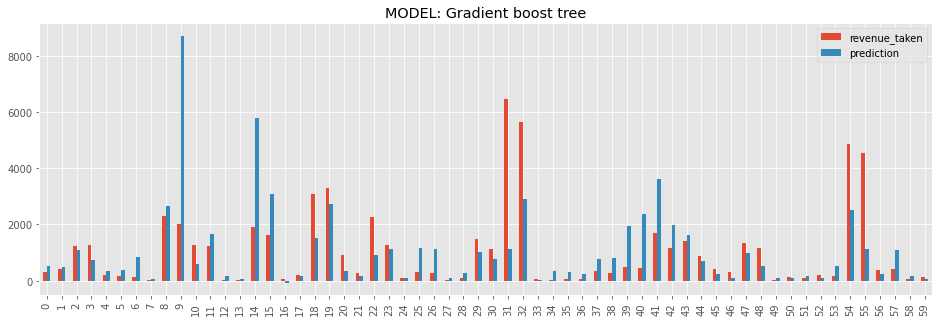

In [109]:
plot_real_vs_pred("Gradient boost tree", y_true_all, y_pred_all)

## 4. Random Forest Regressor

In [79]:
# Import Random Forest Regressor
from pyspark.ml.regression import RandomForestRegressor


rfR_additive = RandomForestRegressor(maxDepth=6, 
                  featuresCol='feature_additive', 
                  labelCol='revenue_taken',
                  ).fit(train)

rfR_internal = RandomForestRegressor(maxDepth=6, 
                  featuresCol='feature_internal', 
                  labelCol='revenue_taken',
                  ).fit(train)

rfR_all = RandomForestRegressor(maxDepth=7, 
                  featuresCol='feature_all', 
                  labelCol='revenue_taken',
                  ).fit(train)

In [80]:
predictions_additive_R = rfR_additive.transform(test)
predictions_internal_R = rfR_internal.transform(test)
predictions_all_R = rfR_all.transform(test)

In [81]:
rmse_addtive_R = evaluator.evaluate(predictions_additive_R)
rmse_internal_R = evaluator.evaluate(predictions_internal_R)
rmse_all_R = evaluator.evaluate(predictions_all_R)
print("Root Mean Squared Error (RMSE) for additive model = %g" % rmse_addtive_R)
print("Root Mean Squared Error (RMSE) for internal interaction model = %g" % rmse_internal_R)
print("Root Mean Squared Error (RMSE) for full model = %g" % rmse_all_R)

Root Mean Squared Error (RMSE) for additive model = 2060.8
Root Mean Squared Error (RMSE) for internal interaction model = 2067.08
Root Mean Squared Error (RMSE) for full model = 1973.4


In [82]:
y_true_additive_R = predictions_additive_R.select("revenue_taken").toPandas()
y_pred_additive_R = predictions_additive_R.select("prediction").toPandas()

y_true_internal_R = predictions_internal_R.select("revenue_taken").toPandas()
y_pred_internal_R = predictions_internal_R.select("prediction").toPandas()

y_true_all_R = predictions_all_R.select("revenue_taken").toPandas()
y_pred_all_R = predictions_all_R.select("prediction").toPandas()


r2_score_additive_R = sklearn.metrics.r2_score(y_true_additive_R, y_pred_additive_R)
r2_score_internal_R = sklearn.metrics.r2_score(y_true_internal_R, y_pred_internal_R)
r2_score_all_R = sklearn.metrics.r2_score(y_true_all_R, y_pred_all_R)
print('r2_score_additive: {:4.3f}'.format(r2_score_additive_R))
print('r2_score_internal: {:4.3f}'.format(r2_score_internal_R))
print('r2_score_all: {:4.3f}'.format(r2_score_all_R))

r2_score_additive: 0.254
r2_score_internal: 0.250
r2_score_all: 0.316


## 5. Transform the total revenue to score

In [120]:
df_all

merchant_name,order_year,order_month,total_earners,median_age,income_median,population_density,category,revenue_level,revenue_taken
A Aliquet Ltd,2021,3,4980.623604961794,45.955320262557386,44348.234836395015,446.43100140347246,home and technology,b,349.5484134530372
A Aliquet Ltd,2021,4,5354.985464077088,44.957488804012904,47087.020093628846,661.3048628221844,home and technology,b,338.07536243758386
A Aliquet Ltd,2021,7,4388.982031619088,44.56853448053012,44286.808317322975,322.56914352472995,home and technology,b,475.18502622308233
A Aliquet Ltd,2021,8,5281.06502903092,41.808178897353294,44432.17706152081,674.1575473010176,home and technology,b,375.8536740741011
A Aliquet Ltd,2021,12,4218.068045625177,44.00092016580645,45702.003770359916,633.7586224746047,home and technology,b,486.47663958043245
A Aliquet Ltd,2022,6,4907.6821031588515,44.52282551974433,46859.1278088761,506.7066383636061,home and technology,b,383.8019227224976
A Aliquet Ltd,2022,8,4587.962567801989,43.09698805802131,45936.13593995373,564.2479724970453,home and technology,b,537.5835117882583
A Arcu Industries,2021,2,3464.1233178609377,46.506422301920416,51956.04631148328,12.921544307761414,outdoors,c,21.744568393051882
A Arcu Industries,2021,12,4631.073949176494,43.00178251688292,45797.775562465315,590.2452906166948,outdoors,c,1582.2315307816057
A Arcu Industries,2022,5,4953.264665124492,41.985087824662386,46570.62536428412,839.7026423642426,outdoors,c,1203.3213130052611


In [121]:
revenue_score = df_all.groupBy(["merchant_name"]).agg(
    sum("revenue_taken").alias("total_revenue"), # response variable
    )

In [122]:
revenue_score

merchant_name,total_revenue
At Augue Corporation,7962.7336540196875
Vel Turpis Company,4249.252604672681
Dictum Mi Limited,69734.58133110827
Amet Nulla Ltd,784.128141246214
Porttitor Eros In...,5076.1197956693895
Malesuada PC,3830.114776275045
Erat Semper Ltd,46434.13428138851
Arcu Vestibulum C...,1487.7112936420851
Varius Orci Insti...,17375.570683881582
Volutpat Nulla In...,60690.059909955526


In [123]:
revenue_score = revenue_score.withColumn("a", lit("a"))

In [126]:
from pyspark.sql.window import Window
from pyspark.sql.functions import percent_rank

In [127]:
Window_Spec  = Window.partitionBy("a").orderBy("total_revenue")
revenue_score = revenue_score.withColumn("percent_rank", percent_rank().over(Window_Spec)) 

In [131]:
revenue_score = revenue_score.withColumn("revenue_score", 1-F.col("percent_rank")).drop("a","percent_rank", "total_revenue")

In [164]:
trend = spark.read.option("header", "true").csv("../data/curated/increasing.csv")

In [178]:
trend = trend.withColumn("increasing", F.col("increasing").cast("double"))

In [179]:
trend

merchant_name,increasing
Eros Non LLP,-980.0837015305178
Tortor Integer Al...,-349.3538636710657
Sodales Limited,-9654.404131067335
Nulla At Sem Limited,-1190.5132491448949
Elementum Dui Ass...,3655.7094516963953
Duis Elementum Corp.,3651.7105101416964
Vel Quam Industries,2727.648449189126
Velit Institute,3164.4211675338756
Dui Limited,1099.1811736678892
Enim Mi Institute,-27943.28252906102


In [216]:
from pyspark.ml.feature import StandardScaler


# VectorAssembler Transformation - Converting column to vector type
assembler_vec = VectorAssembler(inputCols=["increasing"],outputCol="increasing_Vect")
trend_score = assembler_vec.transform(trend)

scaler = StandardScaler(inputCol="increasing_Vect", outputCol="trend_score",
                        withStd=True, withMean=False)



In [217]:
from pyspark.ml.functions import vector_to_array
trend_score = scaler.fit(trend_score).transform(trend_score).drop("increasing","increasing_Vect").withColumn("trend_score", vector_to_array("trend_score")[0])

In [234]:
trend_score = trend_score.withColumnRenamed("merchant_name", "name")

In [240]:
trend_revenue_final = revenue_score.join(trend_score, trend_score.name ==  revenue_score.merchant_name,"inner").drop("name")

In [241]:
trend_revenue_final

merchant_name,revenue_score,trend_score
Consectetuer Ipsu...,1.0,0.012512970918944816
Faucibus Ltd,0.999743062692703,-0.01196818716621...
Ac Eleifend Vitae...,0.9994861253854059,0.011023550264931004
Velit Inc.,0.9992291880781089,-0.00796371495021574
Magna Sed Associates,0.998972250770812,0.013174105188561047
Egestas A Dui Corp.,0.9987153134635149,-0.07457649838314082
Nulla Limited,0.9984583761562179,-0.03087919316331...
Enim Etiam Institute,0.9982014388489209,-0.3129278634926591
Lacus LLP,0.9979445015416238,0.18884255396835822
Orci Ut Institute,0.9976875642343268,0.23816250779671555


In [242]:
trend_revenue_final.count()

3893

In [244]:
trend_revenue_final.write.parquet("../data/curated/revenue_trend_score")